# Defending Against Adversarial Attacks:
In our previous session on adversarial attacks we discussed a few white box attack strategies and demonstrated their use for attack a simple CNN based cat and dog classifier. We saw that when attacks like FGSM or C&W are performed the performance of the CNN model detoriates rapidly. Today we will discuss simple methods that can be used to make models more robust. Adversarial defence is a significantly challenging field and many methods are being proposed. Discussing all these methods are out of the scope of this notebook

# Set up Dataset

In [1]:
!pip install -q kaggle
!gdown --id 1wObfz33pLg8oSVbz8kOMS7zepsFw71kE

Downloading...
From: https://drive.google.com/uc?id=1wObfz33pLg8oSVbz8kOMS7zepsFw71kE
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 111kB/s]


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")
!cp "/content/gdrive/MyDrive/func_files/utils.py" "/content/"

Mounted at /content/gdrive/


In [3]:
from IPython.display import clear_output
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tongpython/cat-and-dog
!mkdir cat-and-dog
!unzip cat-and-dog.zip -d cat-and-dog

!kaggle datasets download -d chetankv/dogs-cats-images
!mkdir test_data
!unzip dogs-cats-images.zip -d test_data
clear_output(wait=False)

In [4]:
!pip install tensorflow==2.1.0
!pip install numpy == 1.18.1
!pip install h5py==2.10.0
!pip install -q foolbox
!pip install -q eagerpy
clear_output(wait=False)

In [5]:
!gdown --id 1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG

Downloading...
From: https://drive.google.com/uc?id=1dGSgM7JFmquK5xdOJ4TuKxB2Idq3UusG
To: /content/model.CNN.hdf5
100% 2.58M/2.58M [00:00<00:00, 191MB/s]


# Import Libraries

In [11]:
import eagerpy as ep
import foolbox
from foolbox import TensorFlowModel
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification
from PIL import Image

import glob
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functools import partial
from utils import loss_plt
IMG_SIZE = 256

# Perform attack on previously trained CNN
In the previous cat and dog classificiation notebooks we trained a shallow CNN network. For this notebook the same CNN is used. As a recap we show the detoriation in performance of the CNN in question when FGSM attack is performed

In [7]:
images = []
labels = []
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/cats/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(0)
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/dogs/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(1)  
images = tf.constant(np.stack(images,axis=0))
labels = tf.constant(np.stack(labels,axis=0))

In [8]:
model = load_model("model.CNN.hdf5")
print(model.input_shape)
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])
fmodel = TensorFlowModel(model, bounds=(0, 255))

(None, 256, 256, 3)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [9]:
print("Initial Model Accuracy:",foolbox.utils.accuracy(fmodel, images, labels))

Initial Model Accuracy: 0.8500000238418579


In [10]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)

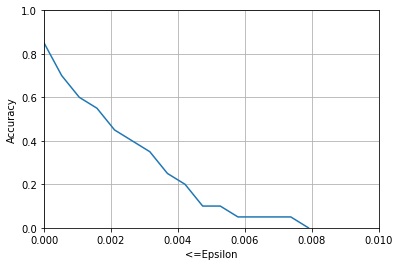

In [11]:
epsilons, accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
plt.figure()
plt.plot(epsilons,accuracy)
plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Ensembling Defence
When a whitebox attack is made, it is done so by targeting a trained model. A simple strategy for mitigation of adversarial attacks can be ensembling of networks [(Strauss et al. 2017)](https://arxiv.org/abs/1709.03423). When an attack is now made by targeting models that are included in the ensemble, owing to the diversity of networks in the ensemble, the impact is expected to be lesser

In [14]:
len_train_set = len(os.listdir('/content/cat-and-dog/training_set/training_set/dogs/'))+len(os.listdir('/content/cat-and-dog/training_set/training_set/cats/'))
len_test_set = len(os.listdir('/content/cat-and-dog/test_set/test_set/dogs/'))+len(os.listdir('/content/cat-and-dog/test_set/test_set/cats/'))

In [13]:
def buildModel():
    # Initialising the CNN
  classifier = tf.keras.models.Sequential()

  # Step 1 - Convolution
  classifier.add(L.Convolution2D(32, 3, 3, input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))

  # Step 2 - Pooling
  classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

  # Adding a second convolutional block
  classifier.add(L.Convolution2D(32, 3, 3, activation = 'relu'))
  classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

  # Step 3 - Flattening
  classifier.add(L.Flatten())

  # Step 4 - Full connection
  classifier.add(L.Dense(128, activation = 'relu'))
  classifier.add(L.Dense(2, activation = 'softmax'))

  # Compiling the CNN
  classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return classifier

In [16]:
NUM_MODELS = 3
models = []

In [17]:
# train an ensemble with 3 models with same architecture
for i in range(NUM_MODELS):
  K.clear_session()
  classifier = buildModel()
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

  test_datagen = ImageDataGenerator(rescale = 1./255)
  training_set = train_datagen.flow_from_directory('/content/cat-and-dog/training_set/training_set',
                                                  target_size = (IMG_SIZE, IMG_SIZE),
                                                  batch_size = 32,
                                                  class_mode = 'categorical')

  test_set = test_datagen.flow_from_directory('/content/cat-and-dog/test_set/test_set',
                                              target_size = (IMG_SIZE, IMG_SIZE),
                                              batch_size = 32,
                                              class_mode = 'categorical')
  chckpt_path = 'model.adCNN.hdf5'
  # loss_plot = loss_plt()

  chckpt  = tf.keras.callbacks.ModelCheckpoint(chckpt_path, save_best_only=True,monitor = 'val_accuracy',mode='max')
  classifier.fit_generator(training_set,
                          steps_per_epoch = len_train_set//32,
                          epochs = 10,
                          validation_data = test_set,
                          validation_steps = len_test_set//32,
                          callbacks=[chckpt]
                          )
  classifier.load_weights(chckpt_path)
  models.append(classifier)
  clear_output(wait=False)

In [18]:
def predict(test_data,models):
  pred = np.zeros((test_data.shape[0],2))
  for model in models:
    pred += model.predict(test_data)
  return np.argmax(pred/len(models),axis=1)

In [19]:
images = []
labels = []
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/cats/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(0)
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/dogs/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(1)  
images = tf.constant(np.stack(images,axis=0))
labels = tf.constant(np.stack(labels,axis=0))

In [20]:
model = load_model("model.CNN.hdf5")
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])
fmodel = TensorFlowModel(model, bounds=(0, 255))

In [22]:
print("Initial Ensemble Model Accuracy:",np.sum(predict(images,models)==labels)/labels.shape[0])
print("Initial CNN Model Accuracy:",foolbox.utils.accuracy(fmodel, images, labels))

Initial Ensemble Model Accuracy: 0.7
Initial CNN Model Accuracy: 0.75


In [23]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)

attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
fmodelad = TensorFlowModel(models[0], bounds=(0, 255))
rawad, clippedad, is_advad = attack(fmodelad , images, Misclassification(labels), epsilons=epsilon)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



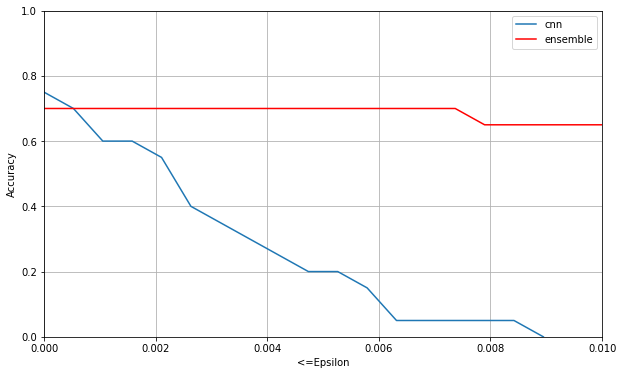

In [26]:
epsilons, accuracy = [],[]
epsilonsad, accuracyad = [],[]

for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = np.sum(predict(advs_,models)==labels)/labels.shape[0]
  # acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  epsilonsad.append(eps)
  accuracyad.append(acc2)
  if acc2 == 0:
      break

plt.figure(figsize=(10,6))
plt.plot(epsilons,accuracy,label='cnn')
plt.plot(epsilonsad,accuracyad,color='red',label='ensemble')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

This attack has been made by calculating the gradients for only one of the models of the ensemble. The more appropriate way would be taking average of the gradients ∇<sub>x</sub>J(θ<sub>i</sub>
, x, y) from all classiers in the ensemble and then modifying the sample.

# Including Adversarial Samples in Training
Another simple strategy to mitigate a certain type of attack is including adversarial samples generated with this attack in the training set and retraining the model. This method however has its disadvantages. If new attacks are made on the retrained model, it may not be able to mitigate them

In [8]:
!cp -r "/content/cat-and-dog" "/content/adverserial/"

In [9]:
def makeAdversarialDataset(batch_size = 8, frac=0.1):
  all_files = glob.glob(os.path.join("/content/adverserial/training_set/training_set/","*/*.jpg"),recursive=True)
  files = np.random.choice(all_files,batch_size*(int(len(all_files)*0.1)//batch_size),replace=False).reshape((-1,batch_size))
  mapper = lambda x: 0 if x=='cats' else 1

  model = load_model("model.CNN.hdf5")
  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])
  fmodel = TensorFlowModel(model, bounds=(0, 255))
  counter_dogs = 0
  counter_cats = 0

  print("Files: ",files.shape)
  for batch in tqdm(files,"creating adversarial samples: "):
    images = []
    labels = []
    for img in batch:
      images.append(np.asarray(Image.open(img).resize((IMG_SIZE,IMG_SIZE)))/255)
      labels.append(mapper(img.split("/")[-2]))
    images = tf.constant(np.stack(images,axis=0))
    labels = tf.constant(np.stack(labels,axis=0))
    
    attack = foolbox.attacks.FGSM()
    epsilon = np.linspace(0.0, 0.01, num=20)
    raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)
    for eps in clipped:
      for im,label in zip(eps,labels):
        temp = Image.fromarray((255*im.numpy()).astype(np.uint8))
        if label==0:
          path = "/content/adverserial/training_set/training_set/cats/"+f'img_cat_{counter_cats}.jpg'
          counter_cats+=1
        else:
          path = "/content/adverserial/training_set/training_set/dogs/"+f'img_dog_{counter_dogs}.jpg'
          counter_dogs+=1
        temp.save(path)
  print("\nTotal Images Created: Cats:",counter_cats,"Dogs:",counter_dogs)

In [13]:
# adversarial samples are added to the train set
makeAdversarialDataset()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Files:  (100, 8)


creating adversarial samples:   0%|          | 0/100 [00:00<?, ?it/s]


Total Images Created: Cats: 8100 Dogs: 7900


In [14]:
len_train_set = len(os.listdir('/content/adverserial/training_set/training_set/dogs/'))+len(os.listdir('/content/adverserial/training_set/training_set/cats/'))
len_test_set = len(os.listdir('/content/adverserial/test_set/test_set/dogs/'))+len(os.listdir('/content/adverserial/test_set/test_set/cats/'))

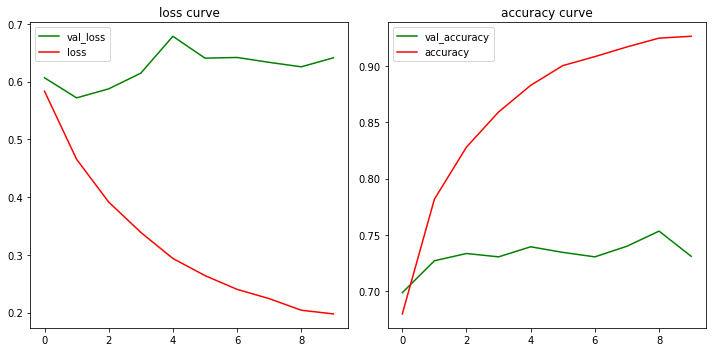

epoch 10/50 loss: 0.198 accuracy: 0.9261 val_loss: 0.641 val_accuracy:0.7312
750/750 [==============================] - 366s 489ms/step - loss: 0.1976 - accuracy: 0.9261 - val_loss: 0.6411 - val_accuracy: 0.7312
[INFO] Best Validation Accuracy:  0.7534722


In [15]:
def buildModel():
  # Initialising the CNN
  classifier = tf.keras.models.Sequential()

  # Step 1 - Convolution
  classifier.add(L.Convolution2D(32, 3, 3, input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))

  # Step 2 - Pooling
  classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

  # Adding a second convolutional block
  classifier.add(L.Convolution2D(32, 3, 3, activation = 'relu'))
  classifier.add(L.MaxPooling2D(pool_size = (2, 2)))

  # Step 3 - Flattening
  classifier.add(L.Flatten())

  # Step 4 - Full connection
  classifier.add(L.Dense(128, activation = 'relu'))
  classifier.add(L.Dense(2, activation = 'softmax'))

  # Compiling the CNN
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return classifier

classifier = buildModel()

# Part 2 - Fitting the CNN to the images

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/adverserial/training_set/training_set',
                                                 target_size = (IMG_SIZE, IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/adverserial/test_set/test_set',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'categorical')
chckpt_path = 'model.adCNN.hdf5'
loss_plot = loss_plt()

chckpt  = tf.keras.callbacks.ModelCheckpoint(chckpt_path, save_best_only=True,monitor = 'val_accuracy',mode='max')
classifier.fit_generator(training_set,
                         steps_per_epoch = len_train_set//32,
                         epochs = 10,
                         validation_data = test_set,
                         validation_steps = len_test_set//32,
                         callbacks=[chckpt, loss_plot]
                         )
classifier.load_weights(chckpt_path)

In [16]:
images = []
labels = []
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/cats/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(0)
for f in glob.glob(os.path.join("/content/test_data/dataset/test_set/dogs/","*.jpg"))[:10]:
  images.append(np.asarray(Image.open(f).resize((IMG_SIZE,IMG_SIZE)))/255)
  labels.append(1)  
images = tf.constant(np.stack(images,axis=0))
labels = tf.constant(np.stack(labels,axis=0))

In [79]:
model = load_model("model.CNN.hdf5")
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])
fmodel = TensorFlowModel(model, bounds=(0, 255))
fmodelad = TensorFlowModel(classifier, bounds=(0, 255))

In [80]:
print("Initial CNN Model Accuracy:",foolbox.utils.accuracy(fmodel, images, labels))
print("Initial Adv CNN Model Accuracy:",foolbox.utils.accuracy(fmodelad, images, labels))

Initial CNN Model Accuracy: 0.8500000238418579
Initial Adv CNN Model Accuracy: 0.699999988079071


Now we perform an attack on the retrained model by targeting the original model. As seen below, the retrained model is impervious to attacks performed on the original model

In [81]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)

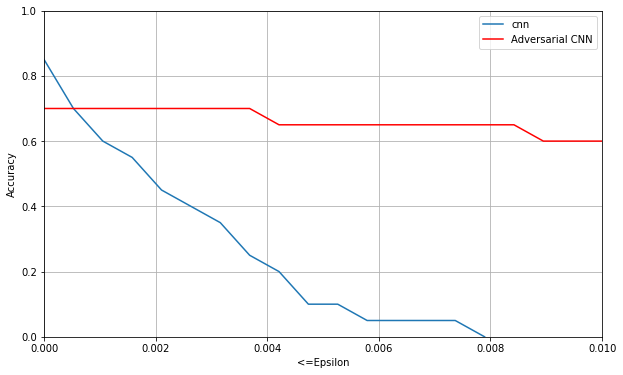

In [82]:
epsilons, accuracy = [],[]
epsilonsad, accuracyad = [],[]

for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  # acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  epsilonsad.append(eps)
  accuracyad.append(acc2)
  if acc2 == 0:
      break

plt.figure(figsize=(10,6))
plt.plot(epsilons,accuracy,label='cnn')
plt.plot(epsilonsad,accuracyad,color='red',label='Adversarial CNN')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

But what happens if the attack is performed on the retrained model itself. As seen below the accuracy still drops. The problem here is that the retrained model and the target model are separate entities. 

In [ ]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
rawad, clippedad, is_advad = attack(fmodelad , images, Misclassification(labels), epsilons=epsilon)

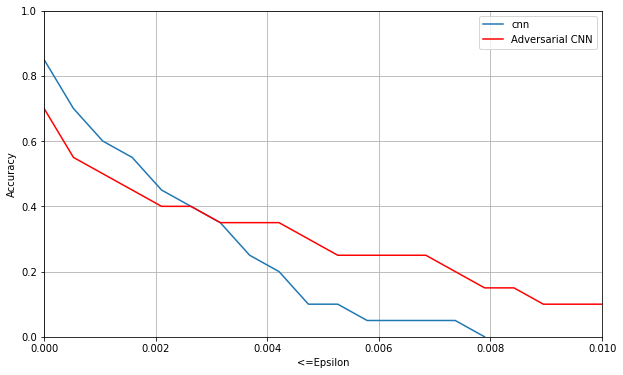

In [83]:
epsilons, accuracy = [],[]
epsilonsad, accuracyad = [],[]

for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clippedad):
  acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  # acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  epsilonsad.append(eps)
  accuracyad.append(acc2)
  if acc2 == 0:
      break

plt.figure(figsize=(10,6))
plt.plot(epsilons,accuracy,label='cnn')
plt.plot(epsilonsad,accuracyad,color='red',label='Adversarial CNN')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Iteratively Train
 
 Addressing the issue raised in the previous section, in this section we iteratively train a model on adversarial samples. Here the model being trained and the target model of the attack are the same. 
![img](https://929687.smushcdn.com/2633864/wp-content/uploads/2021/02/mixed_normal_adversary_step4.png?lossy=1&strip=1&webp=1)

We sample a batch of images, and generate adversarial samples from this set using the model trained till this stage. The adverarial samples are mixed with the original images to obtain a mixed batch. The model is then trained using this batch. This process is performed iteratively

In [57]:
def generateAdversarialBatches(all_files, model):
  print("[INFO] Adversarial Batch Data Generator created")
  mapper = lambda x: 0 if x=='cats' else 1

  while True:
    for batch in all_files:
      images = []
      labels = []
      for img in batch:
        images.append(np.asarray(Image.open(img).resize((IMG_SIZE,IMG_SIZE)))/255)
        labels.append(mapper(img.split("/")[-2]))
      images = tf.constant(np.stack(images,axis=0))
      labels = tf.constant(np.stack(labels,axis=0))
      
      attack = foolbox.attacks.FGSM()
      fmodel = TensorFlowModel(model, bounds=(0, 255))
      epsilon = np.random.choice(np.linspace(0.0, 0.01, num=20),1)[0]
      raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)
    
      images = np.vstack([images.numpy(),clipped.numpy()])
      labels = np.concatenate([labels.numpy(),labels.numpy()])
      yield images,labels

In [74]:
from sklearn.model_selection import train_test_split
def iterativeTrain(model, epochs=10, batch_size=8):
  print("[INFO] Training with Dynamic Adversarial Image Generation")
  all_files = glob.glob(os.path.join("/content/cat-and-dog/training_set/training_set/","*/*.jpg"),recursive=True)
  all_files_trn, all_files_val = train_test_split(all_files,test_size=0.1)
  if len(all_files_trn)%batch_size!=0:
    all_files_trn = all_files_trn[:len(all_files_trn)-(len(all_files_trn)%batch_size)]
  if len(all_files_val)%batch_size!=0:
    all_files_val = all_files_val[:len(all_files_val)-(len(all_files_val)%batch_size)]

  all_files_trn = np.array(all_files_trn).reshape((-1,batch_size))
  all_files_val = np.array(all_files_val).reshape((-1,batch_size))
  
  datagen = generateAdversarialBatches(all_files_trn,model)
  val_datagen = generateAdversarialBatches(all_files_val,model)
  ckpt = tf.keras.callbacks.ModelCheckpoint("advModel.hdf5",monitor='val_loss',mode='min',save_best_only=True)
  
  model.fit(datagen,
            epochs=epochs,
            steps_per_epoch=all_files_trn.shape[0]//batch_size,
            validation_data = val_datagen,
            validation_steps = all_files_val.shape[0]//batch_size,
            callbacks=[ckpt])
  return model

In [75]:
model = load_model("model.CNN.hdf5")
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
             metrics=['accuracy'])
iterativeTrain(model)

[INFO] Training with Dynamic Adversarial Image Generation
[INFO] Adversarial Batch Data Generator created
  ...
    to  
  ['...']
[INFO] Adversarial Batch Data Generator created
  ...
    to  
  ['...']
Train for 112 steps, validate for 12 steps
Epoch 1/10
112/112 [==============================] - 16s 139ms/step - loss: 0.7747 - accuracy: 0.5045 - val_loss: 0.7015 - val_accuracy: 0.4896
Epoch 2/10
112/112 [==============================] - 15s 134ms/step - loss: 0.6820 - accuracy: 0.5698 - val_loss: 0.6730 - val_accuracy: 0.5521
Epoch 3/10
112/112 [==============================] - 15s 132ms/step - loss: 0.6803 - accuracy: 0.5614 - val_loss: 0.6783 - val_accuracy: 0.5938
Epoch 4/10
112/112 [==============================] - 15s 133ms/step - loss: 0.6537 - accuracy: 0.5977 - val_loss: 0.6745 - val_accuracy: 0.5260
Epoch 5/10
112/112 [==============================] - 15s 137ms/step - loss: 0.6387 - accuracy: 0.6362 - val_loss: 0.6412 - val_accuracy: 0.6458
Epoch 6/10
112/112 [========

As before we generate at attack using the original model and test it using the adversarialy trained model. As expected it is impervious to attacks performed on the original model. But what happens when an attack is performed on itself.

In [76]:
fmodel = TensorFlowModel(load_model('model.CNN.hdf5'), bounds=(0, 255))
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
raw, clipped, is_adv = attack(fmodel , images, Misclassification(labels), epsilons=epsilon)

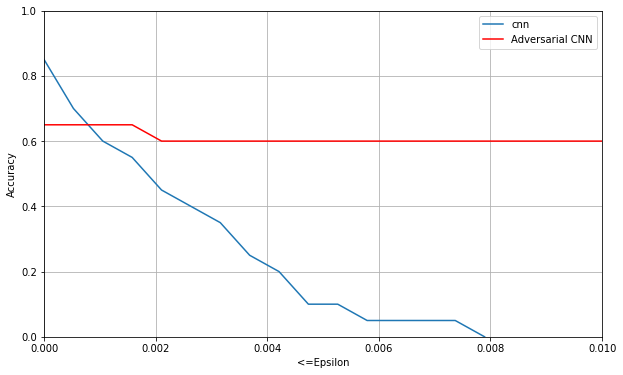

In [77]:
epsilons, accuracy = [],[]
epsilonsad, accuracyad = [],[]

for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  # acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  epsilonsad.append(eps)
  accuracyad.append(acc2)
  if acc2 == 0:
      break

plt.figure(figsize=(10,6))
plt.plot(epsilons,accuracy,label='cnn')
plt.plot(epsilonsad,accuracyad,color='red',label='Adversarial CNN')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Now we perform an attack targeting the adversarialy trained model. Now we see that the model is much more robust to FGSM attacks performed on itself.

In [ ]:
attack = foolbox.attacks.FGSM()
epsilon = np.linspace(0.0, 0.01, num=20)
fmodelad = TensorFlowModel(model, bounds=(0, 255))
rawad, clippedad, is_advad = attack(fmodelad , images, Misclassification(labels), epsilons=epsilon)

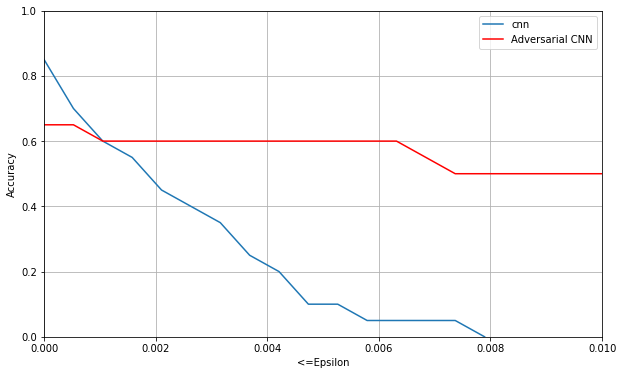

In [78]:
epsilons, accuracy = [],[]
epsilonsad, accuracyad = [],[]

for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clipped):
  acc2 = foolbox.utils.accuracy(fmodel, advs_, labels)
  epsilons.append(eps)
  accuracy.append(acc2)
  if acc2 == 0:
      break
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), clippedad):
  acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  # acc2 = foolbox.utils.accuracy(fmodelad, advs_, labels)
  epsilonsad.append(eps)
  accuracyad.append(acc2)
  if acc2 == 0:
      break

plt.figure(figsize=(10,6))
plt.plot(epsilons,accuracy,label='cnn')
plt.plot(epsilonsad,accuracyad,color='red',label='Adversarial CNN')

plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [84]:
!cp "advModel.hdf5" "/content/gdrive/MyDrive/func_files/"
!cp "model.adCNN.hdf5" "/content/gdrive/MyDrive/func_files/"

drive.flush_and_unmount()